# Visualising synthetic data

## Loading data

In [15]:
# loading ctgan
from sdv.single_table import CTGANSynthesizer

# Loading the model from the pickle file
ctgan = CTGANSynthesizer.load(
    filepath='ctgan_theft_v2.pkl'
)

In [16]:
# loading data
import pandas as pd

df_filtered = pd.read_pickle("df_filtered_theft.pkl")

In [11]:
# Generate 5 samples of size 87517
samples = []
for i in range(5):
    sample = ctgan.sample(num_rows=87517)
    samples.append(sample)
    print(f"Sample {i+1} generated with shape: {sample.shape}")

Sample 1 generated with shape: (87517, 7)
Sample 2 generated with shape: (87517, 7)
Sample 3 generated with shape: (87517, 7)
Sample 4 generated with shape: (87517, 7)
Sample 5 generated with shape: (87517, 7)


In [17]:
# loading lookup file
lookup = pd.read_csv('DataZone2011lookup_2024-12-16.csv', encoding='latin1')

## Generating Heatmaps

In [26]:
# ─────────────────────────── 1. GENERATE SYNTHETIC DATASETS ───────────────────────────
synthetic_datasets = [ctgan.sample(num_rows=87517) for _ in range(5)]

In [27]:
# ─────────────────────────── 2. NORMALIZATION & MATCHING ───────────────────────────
def normalize_ward_name(name: str) -> str:
    """
    Cleans and standardizes a ward name string by removing accents,
    standardizing separators, removing extra whitespace, and converting to lowercase.
    """
    if pd.isnull(name):
        return ""
    # Normalize unicode characters (e.g., accents) and safely convert to ASCII
    name = unicodedata.normalize("NFKD", name).encode("ascii", "ignore").decode()
    # Standardize common separators and characters
    name = name.replace("&", "and").replace("/", ",").replace("'", "").lower()
    # Remove leading/trailing and excess internal whitespace
    return " ".join(name.split()).strip()

# --- Apply Normalization Upfront ---
# Clean the ward names in the primary dataframe. This is crucial if you are
# training your CTGAN model after this step.
print("Normalizing 'multi_member_ward' in the main dataframe...")
df_filtered["multi_member_ward"] = df_filtered["multi_member_ward"].apply(normalize_ward_name)

# Clean the ward names in the lookup table to ensure successful merges later.
# Note: Ensure the column name 'MMWard_Name' is correct for your lookup table.
print("Normalizing 'MMWard_Name' in the lookup table...")
lookup["MMWard_Name"] = lookup["MMWard_Name"].apply(normalize_ward_name)
print("Normalization complete.")

Normalizing 'multi_member_ward' in the main dataframe...
Normalizing 'MMWard_Name' in the lookup table...
Normalization complete.


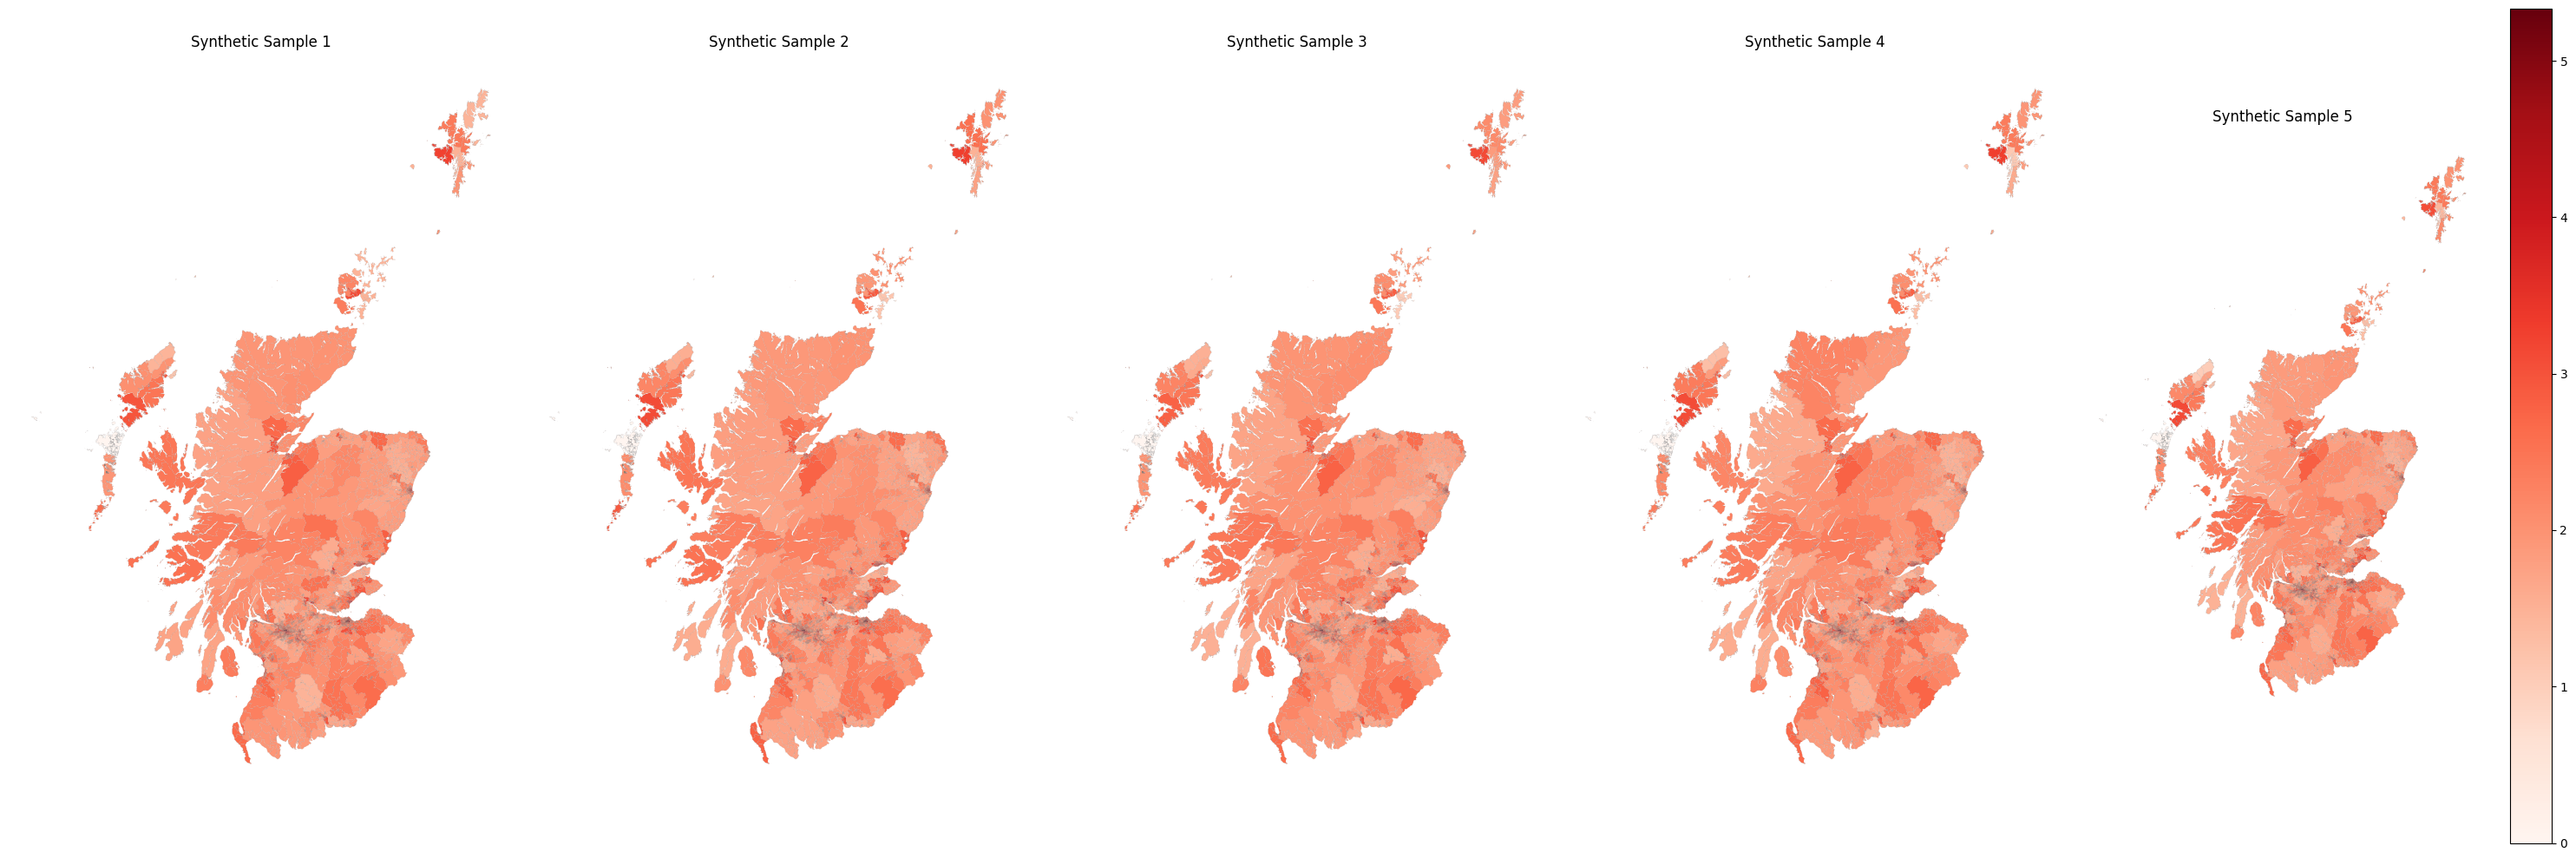

In [28]:
def match_ward(name):
    cleaned = normalize_ward_name(name)
    match, score, _ = process.extractOne(
        cleaned, real_clean.keys(), scorer=fuzz.token_sort_ratio
    )
    return real_clean[match] if score > 85 else name

# ─────────────────────────── 3. COUNTING & EXPANSION HELPERS ───────────────────────────
lookup = (
    lookup
    .rename(columns={"DZ2011_Code": "DataZone"})
    [["DataZone", "MMWard_Name"]]
)
dz_per_ward = lookup.groupby("MMWard_Name").size().rename("n_dz").reset_index()

def expand_to_dz(ward_counts: pd.DataFrame) -> pd.DataFrame:
    out = (
        ward_counts
        .merge(lookup, on="MMWard_Name", how="left")
        .merge(dz_per_ward, on="MMWard_Name", how="left")
    )
    out["dz_incidents"] = out["ward_incidents"] / out["n_dz"]
    return out[["DataZone", "dz_incidents"]]

def attach_counts(gdf_base: gpd.GeoDataFrame, dz_counts: pd.DataFrame) -> gpd.GeoDataFrame:
    gdf = gdf_base.merge(dz_counts, on="DataZone", how="left").fillna({"dz_incidents": 0})
    gdf["log_inc"] = np.log1p(gdf["dz_incidents"])
    return gdf

# ─────────────────────────── 4. LOAD SHAPEFILE ───────────────────────────
shp_path = "shape_files/SG_DataZone_Bdry_2011.shp"
shp = (
    gpd.read_file(shp_path)
    .rename(columns={"DZ_CODE": "DataZone"})
    .to_crs(epsg=4326)
)

# ─────────────────────────── 5. PROCESS OBSERVED DATA ───────────────────────────
df_filtered["incident_count"] = 1
obs_ward = (
    df_filtered
    .groupby("multi_member_ward", as_index=False)["incident_count"]
    .sum()
    .rename(columns={
        "multi_member_ward": "MMWard_Name",
        "incident_count": "ward_incidents"
    })
)
obs_dz = expand_to_dz(obs_ward)
gdf_obs = attach_counts(shp, obs_dz)

# ─────────────────────────── 6. BUILD GeoDataFrames FOR SYNTHETIC SAMPLES ───────────────────────────
gdf_syn_list = []
for syn_data in synthetic_datasets:
    # fuzzy-match ward names
    syn_data["multi_member_ward"] = syn_data["multi_member_ward"].map(match_ward)
    # count incidents
    syn_data["incident_count"] = 1
    syn_ward = (
        syn_data
        .groupby("multi_member_ward", as_index=False)["incident_count"]
        .sum()
        .rename(columns={
            "multi_member_ward": "MMWard_Name",
            "incident_count": "ward_incidents"
        })
    )
    syn_dz = expand_to_dz(syn_ward)
    gdf_syn = attach_counts(shp, syn_dz)
    gdf_syn_list.append(gdf_syn)

# ─────────────────────────── 7. COMPUTE GLOBAL COLOR SCALE ───────────────────────────
all_logs = np.concatenate([gdf["log_inc"].values for gdf in gdf_syn_list])
vmin, vmax = all_logs.min(), all_logs.max()

# ─────────────────────────── 8. PLOT 5 HEATMAPS SIDE-BY-SIDE ───────────────────────────
fig, axes = plt.subplots(1, 5, figsize=(30, 10), sharex=True, sharey=True)

for i, (gdf_syn, ax) in enumerate(zip(gdf_syn_list, axes)):
    gdf_syn.plot(
        column="log_inc",
        ax=ax,
        cmap="Reds",
        vmin=vmin,
        vmax=vmax,
        legend=(i == 4),
        edgecolor="grey",
        linewidth=0.05
    )
    ax.set_title(f"Synthetic Sample {i+1}", fontsize=12)
    ax.axis("off")

plt.tight_layout()
plt.show()